In [9]:
import psycopg2
from dotenv import load_dotenv
import os

In [10]:
def connect_to_supabase():
    try:
        # Load environment variables from .env
        load_dotenv()

        # Fetch variables
        USER = os.getenv("user")
        PASSWORD = os.getenv("password")
        HOST = os.getenv("host")
        PORT = os.getenv("port")
        DBNAME = os.getenv("dbname")

        connection = psycopg2.connect(
            user=USER,
            password=PASSWORD,
            host=HOST,
            port=PORT,
            dbname=DBNAME,
            # Add these parameters to force password authentication
            sslmode='require',  # Supabase requires SSL
            gssencmode='disable',  # Disable GSSAPI
        )
        print("Connection successful!")

        cursor = connection.cursor()
        cursor.execute("SELECT NOW();")
        result = cursor.fetchone()
        print("Current Time:", result)
        return connection, cursor
    except Exception as e:
        print(f"Failed to connect: {e}")
        return None, None

def close_connection(connection, cursor):
    # Close the cursor and connection
    if cursor:
        cursor.close()
        print("Cursor closed.")
    if connection:
        connection.close()
        print("Connection closed.")

        
connection, cursor = connect_to_supabase()

if cursor is not None:
    query = """SELECT w.recorded_at, w.unit, w.water_level, alert_level, minor_flood_level, major_flood_level 
            FROM water_level_measurement as w 
            INNER JOIN gauging_station as g 
            ON w.station_id = g.station_id 
            WHERE g.station_id = 1"""
            
    cursor.execute(query)
    rows = cursor.fetchall()
    count = 0
    for row in rows:
        count += 1
        print(row)
    print("Total rows:", count)
else:
    print("Database connection failed. Cannot execute query.")


Connection successful!
Current Time: (datetime.datetime(2025, 5, 18, 5, 40, 10, 114926, tzinfo=datetime.timezone.utc),)
(datetime.datetime(2021, 3, 27, 8, 0), 'ft', 1.1, 4.0, 5.0, 7.0)
(datetime.datetime(2021, 3, 27, 9, 0), 'ft', 1.2, 4.0, 5.0, 7.0)
(datetime.datetime(2021, 4, 23, 8, 0), 'ft', 1.3, 4.0, 5.0, 7.0)
(datetime.datetime(2021, 4, 23, 9, 0), 'ft', 1.7, 4.0, 5.0, 7.0)
(datetime.datetime(2021, 4, 30, 8, 0), 'ft', 1.0, 4.0, 5.0, 7.0)
(datetime.datetime(2021, 4, 30, 9, 0), 'ft', 0.8, 4.0, 5.0, 7.0)
(datetime.datetime(2021, 5, 2, 8, 0), 'ft', 1.3, 4.0, 5.0, 7.0)
(datetime.datetime(2021, 5, 2, 9, 0), 'ft', 1.1, 4.0, 5.0, 7.0)
(datetime.datetime(2021, 5, 4, 8, 0), 'ft', 2.3, 4.0, 5.0, 7.0)
(datetime.datetime(2021, 5, 4, 9, 0), 'ft', 2.3, 4.0, 5.0, 7.0)
(datetime.datetime(2021, 5, 5, 8, 0), 'ft', 2.1, 4.0, 5.0, 7.0)
(datetime.datetime(2021, 5, 5, 9, 0), 'ft', 2.25, 4.0, 5.0, 7.0)
(datetime.datetime(2021, 5, 6, 8, 0), 'ft', 1.65, 4.0, 5.0, 7.0)
(datetime.datetime(2021, 5, 6, 9, 0), 'f

In [3]:
import psycopg2
from dotenv import load_dotenv
import os

def connect_to_supabase():
    load_dotenv()

    USER = os.getenv("user")
    PASSWORD = os.getenv("password")
    HOST = os.getenv("host")
    PORT = os.getenv("port")
    DBNAME = os.getenv("dbname")

    try:
        connection = psycopg2.connect(
            user=USER,
            password=PASSWORD,
            host=HOST,
            port=PORT,
            dbname=DBNAME,
            sslmode='require',
            gssencmode='disable',
        )
        return connection
    except Exception as error:
        print("Error connecting to database:", error)
        return None

def print_tables_and_columns(connection):
    cursor = connection.cursor()
    try:
        cursor.execute("""
            SELECT table_name, column_name, data_type
            FROM information_schema.columns
            WHERE table_schema = 'public'
            ORDER BY table_name, ordinal_position;
        """)
        rows = cursor.fetchall()

        current_table = None
        for table_name, column_name, data_type in rows:
            if table_name != current_table:
                print(f"\n📋 Table: {table_name}")
                current_table = table_name
            print(f"   • {column_name} ({data_type})")
    except Exception as e:
        print("Error fetching schema:", e)
    finally:
        cursor.close()

def main():
    connection = connect_to_supabase()
    if connection:
        print_tables_and_columns(connection)
        connection.close()

if __name__ == "__main__":
    main()


📋 Table: gauging_station
   • station_id (integer)
   • station_name (character varying)
   • tributary_or_river_id (integer)
   • measurement_unit (character varying)
   • alert_level (double precision)
   • minor_flood_level (double precision)
   • major_flood_level (double precision)
   • coordinate_wgs84 (USER-DEFINED)
   • drainage_area_sqkm (double precision)

📋 Table: geography_columns
   • f_table_catalog (name)
   • f_table_schema (name)
   • f_table_name (name)
   • f_geography_column (name)
   • coord_dimension (integer)
   • srid (integer)
   • type (text)

📋 Table: geometry_columns
   • f_table_catalog (character varying)
   • f_table_schema (name)
   • f_table_name (name)
   • f_geometry_column (name)
   • coord_dimension (integer)
   • srid (integer)
   • type (character varying)

📋 Table: rainfall_measurement
   • station_id (integer)
   • end_time (timestamp without time zone)
   • duration_hours (integer)
   • rainfall_in_mm (double precision)

📋 Table: river_basin
 

In [11]:
def get_water_level_data(station_id,cursor):
     
     #get water level data
     query = f"""
          SELECT recorded_at, unit, water_level FROM water_level_measurement WHERE station_id = {station_id} ORDER BY recorded_at
     """

     cursor.execute(query)
     water_level_data_rows = cursor.fetchall()
     count =0 
     
     for row in water_level_data_rows:
          count += 1
          print(row)
        
     return water_level_data_rows

In [12]:
connection, cursor = connect_to_supabase()

Connection successful!
Current Time: (datetime.datetime(2025, 5, 18, 5, 40, 29, 57349, tzinfo=datetime.timezone.utc),)


In [21]:
def get_station_data(station_name,cursor):
    station_name = station_name.lower().strip()
    query =  f"""
          SELECT 
          station_id,
          alert_level,
          minor_flood_level,
          major_flood_level,
          ST_X(coordinate_wgs84::geometry) AS longitude, 
          ST_Y(coordinate_wgs84::geometry) AS latitude
          FROM gauging_station WHERE station_name ='{station_name}'
     """
    cursor.execute(query)
    flood_level_data_rows = cursor.fetchall()

    station_id = flood_level_data_rows[0][0]
    alert_level = flood_level_data_rows[0][1]
    minor_flood_level = flood_level_data_rows[0][2]
    major_flood_level = flood_level_data_rows[0][3]   
    longitude = flood_level_data_rows[0][4]
    latitude = flood_level_data_rows[0][5]

    gauging_station_data = {
        "station_id": station_id,
        "alert_level": alert_level,
        "minor_flood_level": minor_flood_level,
        "major_flood_level": major_flood_level,
        "longitude": longitude,
        "latitude": latitude
    }
    
    return gauging_station_data

In [22]:
def get_rainfall_data(station_id, cursor):
    # Get rainfall data
    query = f"""
        SELECT end_time, duration_hours, rainfall_in_mm 
        FROM rainfall_measurement 
        WHERE station_id = {station_id}
        ORDER BY end_time
    """
    
    cursor.execute(query)
    rainfall_data_rows = cursor.fetchall()
    count = 0
    
    for row in rainfall_data_rows:
        count += 1
        print(row)
    
    return rainfall_data_rows

In [24]:
import pandas as pd
import os

def main():
    station_name = "hanwella"
    
    connection, cursor = connect_to_supabase()
    
    gauging_station_data = get_station_data(station_name,cursor)
    
    water_level_data_rows = get_water_level_data(gauging_station_data["station_id"],cursor)
    rainfall_data_rows = get_rainfall_data(gauging_station_data["station_id"],cursor)
    
    # Convert the data to a dataframe
    gauging_station_data_df = pd.DataFrame([gauging_station_data])
    water_level_df = pd.DataFrame(water_level_data_rows, columns=["recorded_at", "unit", "water_level"])
    rainfall_df = pd.DataFrame(rainfall_data_rows, columns=["end_time", "duration_hours", "rainfall_in_mm"])
    
    # Set the 'recorded_at' column as the index
    water_level_df.set_index('recorded_at', inplace=True)
    rainfall_df.set_index('end_time', inplace=True)

    # Drop rows with NaN values
    water_level_df.dropna(inplace=True)   
    rainfall_df.dropna(inplace=True)
    
    # Create data directory if it doesn't exist
    os.makedirs('./data', exist_ok=True)
    
    #save the dataframes to csv files
    gauging_station_data_df.to_csv(f'{station_name}_station_data.csv', index=False)
    water_level_df.to_csv(f'./data/{station_name}_water_level_data.csv')
    rainfall_df.to_csv(f'./data/{station_name}_rainfall_data.csv')
    print("Data saved to CSV files.")
    close_connection(connection, cursor)

main()

Connection successful!
Current Time: (datetime.datetime(2025, 5, 18, 5, 48, 27, 542815, tzinfo=datetime.timezone.utc),)
Current Time: (datetime.datetime(2025, 5, 18, 5, 48, 27, 542815, tzinfo=datetime.timezone.utc),)
(datetime.datetime(2021, 3, 27, 8, 0), 'm', 0.74)
(datetime.datetime(2021, 3, 27, 9, 0), 'm', 0.74)
(datetime.datetime(2021, 4, 23, 8, 0), 'm', 3.38)
(datetime.datetime(2021, 4, 23, 9, 0), 'm', 3.52)
(datetime.datetime(2021, 4, 30, 8, 0), 'm', 1.79)
(datetime.datetime(2021, 4, 30, 9, 0), 'm', 1.77)
(datetime.datetime(2021, 5, 2, 8, 0), 'm', 1.19)
(datetime.datetime(2021, 5, 2, 9, 0), 'm', 1.19)
(datetime.datetime(2021, 5, 4, 8, 0), 'm', 4.51)
(datetime.datetime(2021, 5, 4, 9, 0), 'm', 4.4)
(datetime.datetime(2021, 5, 5, 8, 0), 'm', 3.46)
(datetime.datetime(2021, 5, 5, 9, 0), 'm', 3.39)
(datetime.datetime(2021, 5, 6, 8, 0), 'm', 1.96)
(datetime.datetime(2021, 5, 6, 9, 0), 'm', 1.93)
(datetime.datetime(2021, 5, 7, 8, 0), 'm', 3.12)
(datetime.datetime(2021, 5, 7, 9, 0), 'm', 


===== Station Data for Hanwella =====

   station_id  alert_level  minor_flood_level  major_flood_level  longitude  \
0           2          7.0                8.0               10.0  80.084211   

   latitude  
0  6.910939  

===== Water Level Data Summary =====

Total records: 2465
Date range: 2021-03-27 08:00:00 to 2025-03-25 09:00:00
Min water level: 0.21
Max water level: 9.2
Average water level: 4.05

===== Rainfall Data Summary =====

Total records: 1237
Date range: 2021-03-27 09:00:00 to 2025-03-25 08:30:00
Min rainfall: 0.0
Max rainfall: 275.7
Average rainfall: 16.88
Total rainfall: 20884.20 mm


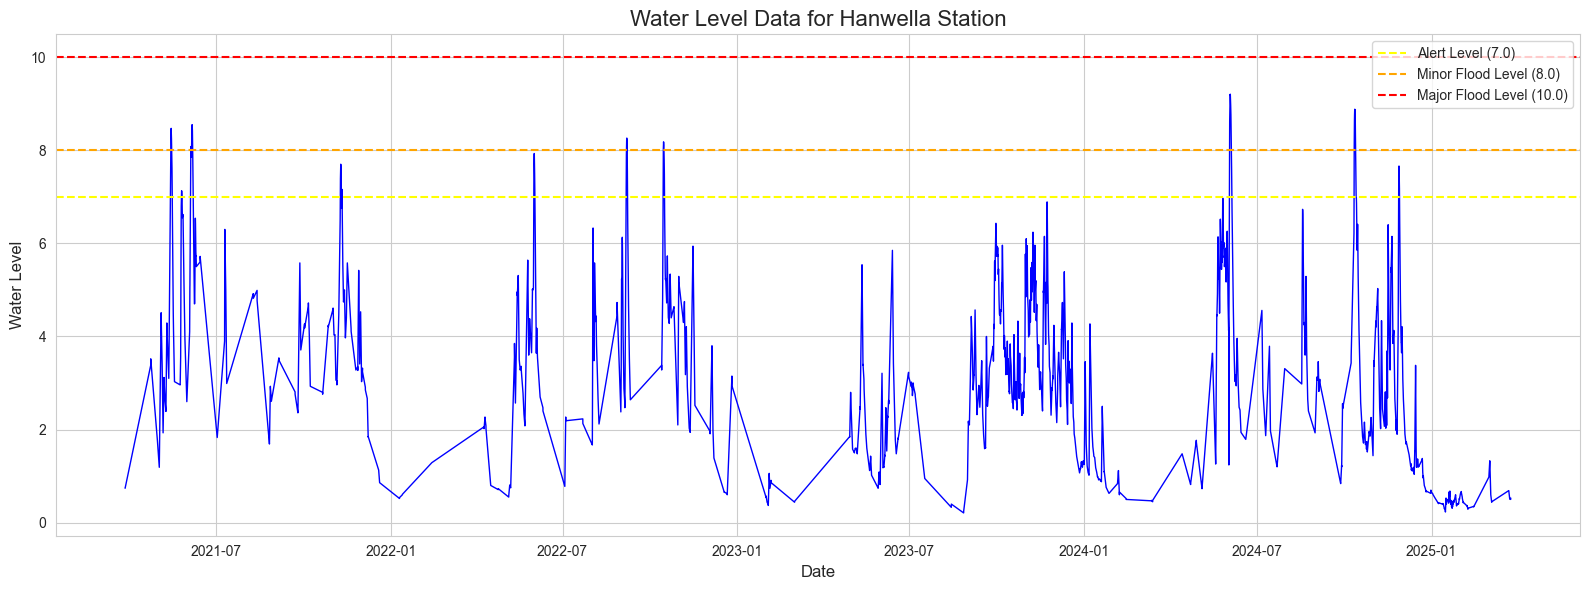

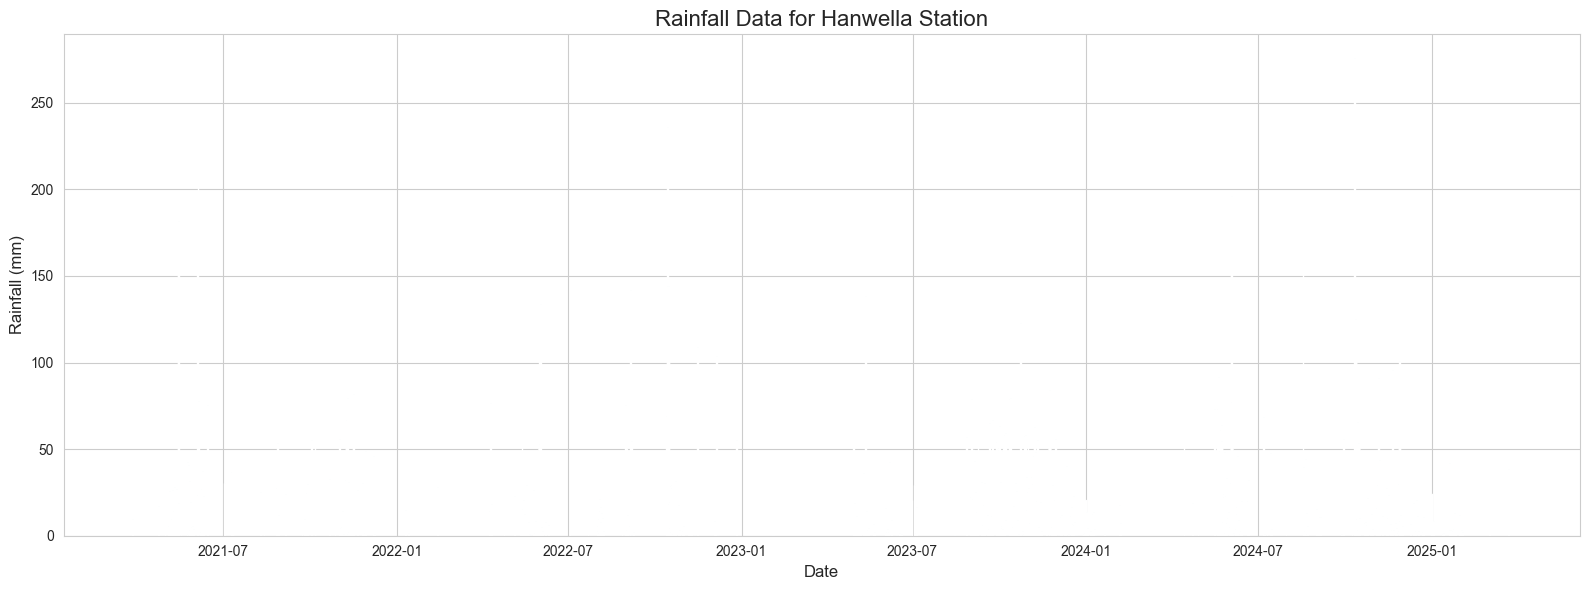

TypeError: agg function failed [how->mean,dtype->object]

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set style for better visualizations
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

# Load the saved CSV files
station_name = "hanwella"
station_data = pd.read_csv(f'{station_name}_station_data.csv')
water_level_data = pd.read_csv(f'./data/{station_name}_water_level_data.csv')
rainfall_data = pd.read_csv(f'./data/{station_name}_rainfall_data.csv')

# Convert date columns to datetime
water_level_data['recorded_at'] = pd.to_datetime(water_level_data['recorded_at'])
rainfall_data['end_time'] = pd.to_datetime(rainfall_data['end_time'])

# Set date columns as index
water_level_data.set_index('recorded_at', inplace=True)
rainfall_data.set_index('end_time', inplace=True)

# Display basic information about the datasets
print(f"\n===== Station Data for {station_name.capitalize()} =====\n")
print(station_data)

print(f"\n===== Water Level Data Summary =====\n")
print(f"Total records: {len(water_level_data)}")
print(f"Date range: {water_level_data.index.min()} to {water_level_data.index.max()}")
print(f"Min water level: {water_level_data['water_level'].min()}")
print(f"Max water level: {water_level_data['water_level'].max()}")
print(f"Average water level: {water_level_data['water_level'].mean():.2f}")

print(f"\n===== Rainfall Data Summary =====\n")
print(f"Total records: {len(rainfall_data)}")
print(f"Date range: {rainfall_data.index.min()} to {rainfall_data.index.max()}")
print(f"Min rainfall: {rainfall_data['rainfall_in_mm'].min()}")
print(f"Max rainfall: {rainfall_data['rainfall_in_mm'].max()}")
print(f"Average rainfall: {rainfall_data['rainfall_in_mm'].mean():.2f}")
print(f"Total rainfall: {rainfall_data['rainfall_in_mm'].sum():.2f} mm")

# Plot the water level data
plt.figure(figsize=(16, 6))
plt.title(f'Water Level Data for {station_name.capitalize()} Station', fontsize=16)
plt.plot(water_level_data.index, water_level_data['water_level'], color='blue', linewidth=1)

# Add alert and flood levels from station data if available
if 'alert_level' in station_data.columns:
    alert_level = station_data['alert_level'].values[0]
    plt.axhline(y=alert_level, color='yellow', linestyle='--', label=f'Alert Level ({alert_level})')

if 'minor_flood_level' in station_data.columns:
    minor_flood = station_data['minor_flood_level'].values[0]
    plt.axhline(y=minor_flood, color='orange', linestyle='--', label=f'Minor Flood Level ({minor_flood})')
    
if 'major_flood_level' in station_data.columns:
    major_flood = station_data['major_flood_level'].values[0]
    plt.axhline(y=major_flood, color='red', linestyle='--', label=f'Major Flood Level ({major_flood})')
    
plt.xlabel('Date', fontsize=12)
plt.ylabel('Water Level', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot the rainfall data
plt.figure(figsize=(16, 6))
plt.title(f'Rainfall Data for {station_name.capitalize()} Station', fontsize=16)
plt.bar(rainfall_data.index, rainfall_data['rainfall_in_mm'], color='skyblue', width=0.8)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Rainfall (mm)', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

# Show correlation between rainfall and water level
# First, resample both datasets to daily frequency to align them
daily_water = water_level_data.resample('D').mean()
daily_rainfall = rainfall_data.resample('D').sum()

# Merge the two datasets
merged_data = pd.merge(daily_water, daily_rainfall, 
                      left_index=True, right_index=True, 
                      how='inner')

if not merged_data.empty:
    # Plot correlation
    plt.figure(figsize=(10, 8))
    plt.title('Correlation between Rainfall and Water Level', fontsize=16)
    plt.scatter(merged_data['rainfall_in_mm'], merged_data['water_level'], alpha=0.6)
    plt.xlabel('Rainfall (mm)', fontsize=12)
    plt.ylabel('Water Level', fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Calculate correlation coefficient
    correlation = merged_data['rainfall_in_mm'].corr(merged_data['water_level'])
    print(f"\nCorrelation between rainfall and water level: {correlation:.3f}")
else:
    print("\nNo overlapping data between rainfall and water level to calculate correlation.")



===== Station Data for Hanwella =====

   station_id  alert_level  minor_flood_level  major_flood_level  longitude  \
0           2          7.0                8.0               10.0  80.084211   

   latitude  
0  6.910939  

===== Water Level Data Summary =====

Total records: 2465
Date range: 2021-03-27 08:00:00 to 2025-03-25 09:00:00
Min water level: 0.21
Max water level: 9.2
Average water level: 4.05

===== Rainfall Data Summary =====

Total records: 1237
Date range: 2021-03-27 09:00:00 to 2025-03-25 08:30:00
Min rainfall: 0.0
Max rainfall: 275.7
Average rainfall: 16.88
Total rainfall: 20884.20 mm


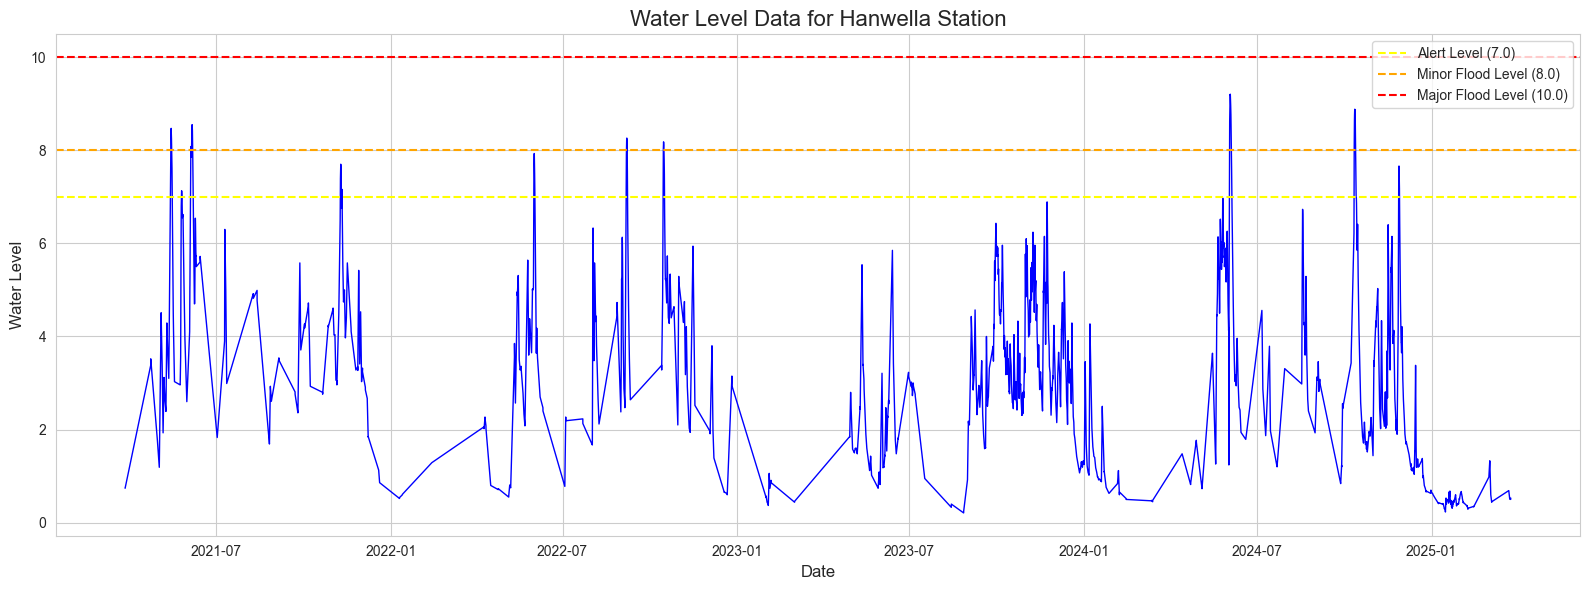

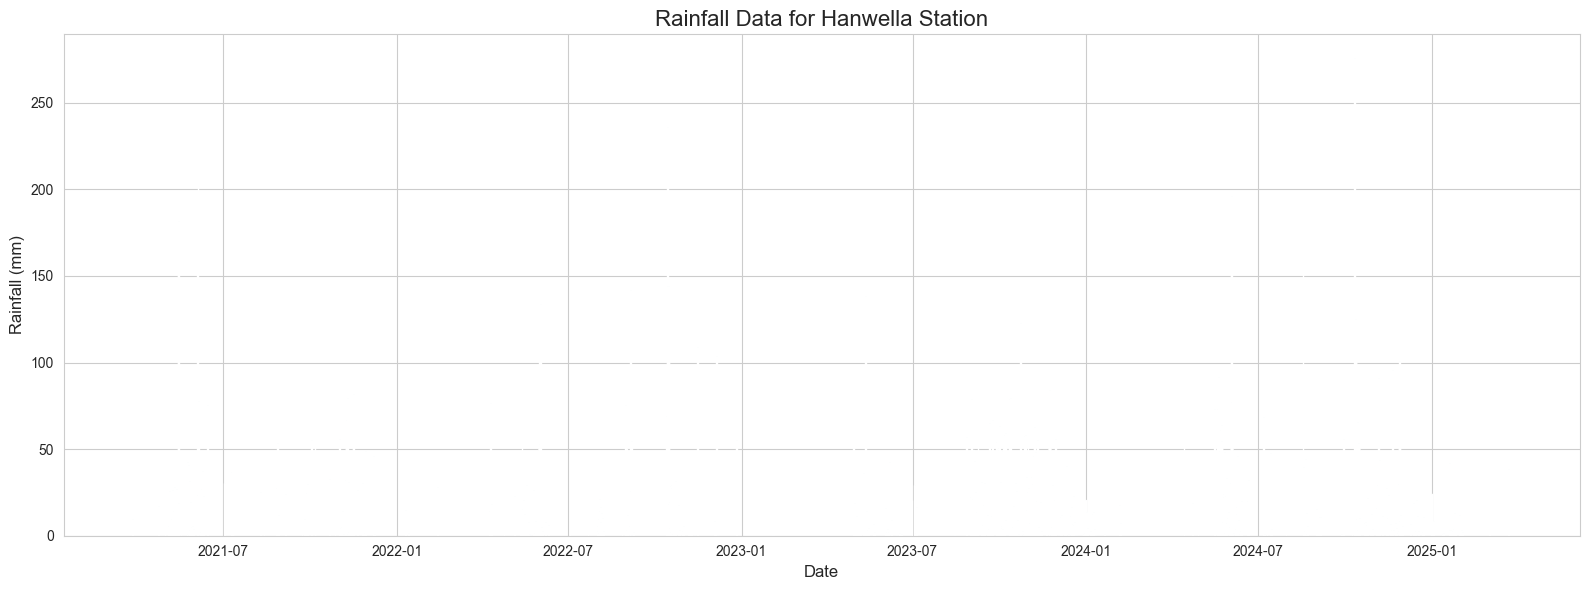

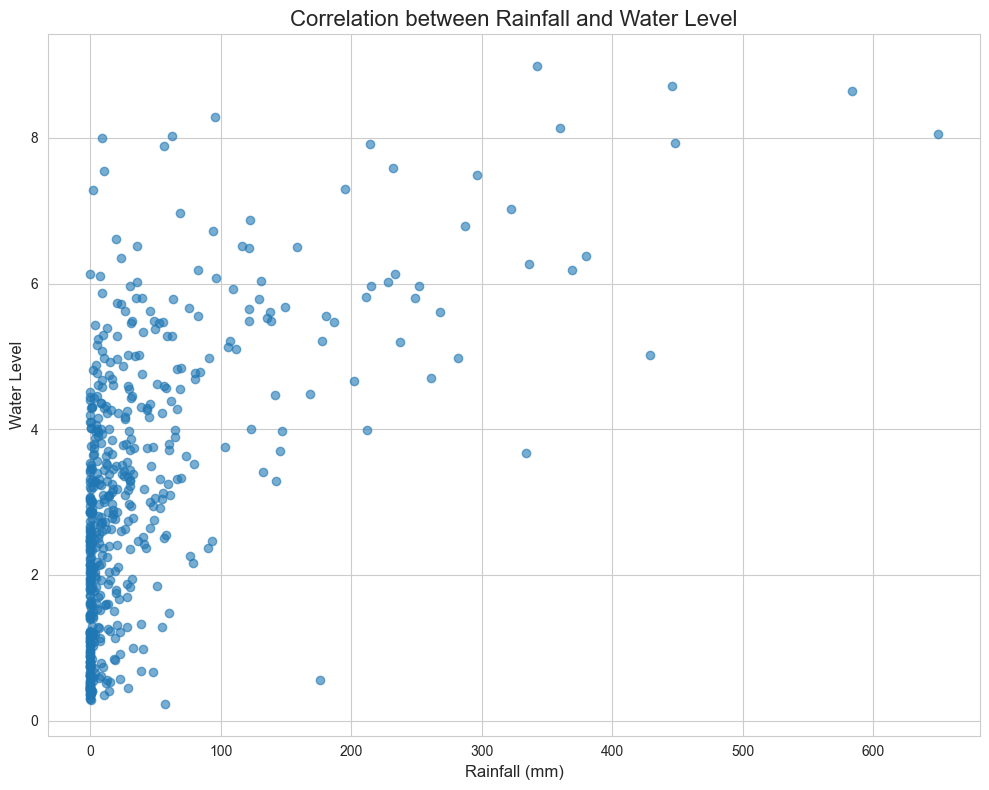


Correlation between rainfall and water level: 0.577


In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set style for better visualizations
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

# Load the saved CSV files
station_name = "hanwella"
station_data = pd.read_csv(f'{station_name}_station_data.csv')
water_level_data = pd.read_csv(f'./data/{station_name}_water_level_data.csv')
rainfall_data = pd.read_csv(f'./data/{station_name}_rainfall_data.csv')

# Convert date columns to datetime
water_level_data['recorded_at'] = pd.to_datetime(water_level_data['recorded_at'])
rainfall_data['end_time'] = pd.to_datetime(rainfall_data['end_time'])

# Set date columns as index
water_level_data.set_index('recorded_at', inplace=True)
rainfall_data.set_index('end_time', inplace=True)

# Display basic information about the datasets
print(f"\n===== Station Data for {station_name.capitalize()} =====\n")
print(station_data)

print(f"\n===== Water Level Data Summary =====\n")
print(f"Total records: {len(water_level_data)}")
print(f"Date range: {water_level_data.index.min()} to {water_level_data.index.max()}")
print(f"Min water level: {water_level_data['water_level'].min()}")
print(f"Max water level: {water_level_data['water_level'].max()}")
print(f"Average water level: {water_level_data['water_level'].mean():.2f}")

print(f"\n===== Rainfall Data Summary =====\n")
print(f"Total records: {len(rainfall_data)}")
print(f"Date range: {rainfall_data.index.min()} to {rainfall_data.index.max()}")
print(f"Min rainfall: {rainfall_data['rainfall_in_mm'].min()}")
print(f"Max rainfall: {rainfall_data['rainfall_in_mm'].max()}")
print(f"Average rainfall: {rainfall_data['rainfall_in_mm'].mean():.2f}")
print(f"Total rainfall: {rainfall_data['rainfall_in_mm'].sum():.2f} mm")

# Plot the water level data
plt.figure(figsize=(16, 6))
plt.title(f'Water Level Data for {station_name.capitalize()} Station', fontsize=16)
plt.plot(water_level_data.index, water_level_data['water_level'], color='blue', linewidth=1)

# Add alert and flood levels from station data if available
if 'alert_level' in station_data.columns:
    alert_level = station_data['alert_level'].values[0]
    plt.axhline(y=alert_level, color='yellow', linestyle='--', label=f'Alert Level ({alert_level})')

if 'minor_flood_level' in station_data.columns:
    minor_flood = station_data['minor_flood_level'].values[0]
    plt.axhline(y=minor_flood, color='orange', linestyle='--', label=f'Minor Flood Level ({minor_flood})')
    
if 'major_flood_level' in station_data.columns:
    major_flood = station_data['major_flood_level'].values[0]
    plt.axhline(y=major_flood, color='red', linestyle='--', label=f'Major Flood Level ({major_flood})')
    
plt.xlabel('Date', fontsize=12)
plt.ylabel('Water Level', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot the rainfall data
plt.figure(figsize=(16, 6))
plt.title(f'Rainfall Data for {station_name.capitalize()} Station', fontsize=16)
plt.bar(rainfall_data.index, rainfall_data['rainfall_in_mm'], color='skyblue', width=0.8)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Rainfall (mm)', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

# Show correlation between rainfall and water level
# First, make sure we're only using numeric columns for resampling
water_level_numeric = water_level_data.select_dtypes(include=['number'])

# Now resample safely using only numeric columns
daily_water = water_level_numeric.resample('D').mean()
daily_rainfall = rainfall_data['rainfall_in_mm'].resample('D').sum()

# Create a DataFrame with both daily data
daily_data = pd.DataFrame()
daily_data['water_level'] = daily_water['water_level']
daily_data['rainfall_in_mm'] = daily_rainfall

# Drop any rows with missing values
daily_data = daily_data.dropna()

if not daily_data.empty:
    # Plot correlation
    plt.figure(figsize=(10, 8))
    plt.title('Correlation between Rainfall and Water Level', fontsize=16)
    plt.scatter(daily_data['rainfall_in_mm'], daily_data['water_level'], alpha=0.6)
    plt.xlabel('Rainfall (mm)', fontsize=12)
    plt.ylabel('Water Level', fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Calculate correlation coefficient
    correlation = daily_data['rainfall_in_mm'].corr(daily_data['water_level'])
    print(f"\nCorrelation between rainfall and water level: {correlation:.3f}")
else:
    print("\nNo overlapping data between rainfall and water level to calculate correlation.")
